In [41]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import sklearn
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [42]:
df_gspc = yf.download('^GSPC', start="1994-01-07", end="2019-09-01", interval="1d")
df_gspc = df_gspc[["Close"]]
df_ftse = yf.download("^FTSE", start="1994-01-07", end="2019-09-01", interval="1d")
df_ftse = df_ftse[["Close"]]
df_n225 = yf.download("^N225", start="1994-01-07", end="2019-09-01", interval="1d")
df_n225 = df_n225[["Close"]]
df_gdaxi = yf.download("^GDAXI", start="1994-01-07", end="2019-09-01", interval="1d")
df_gdaxi = df_gdaxi[["Close"]]

#merge all dataframes
df = df_gspc.join(df_ftse, how="outer", lsuffix="_gspc", rsuffix="_ftse")
df = df.join(df_n225, how="outer", rsuffix="_n225")
df = df.join(df_gdaxi, how="outer", rsuffix="_gdaxi")
df.columns = ["gspc", "ftse", "n225", "gdaxi"]

# columns names spx, dax, ftse, nikkei
df = df.rename(columns={"gspc": "spx", "gdaxi": "dax", "ftse": "ftse", "n225": "nikkei"})
df = df.asfreq("b")  # Business day frequency
df = df.fillna(method="ffill")  # Forward fill to handle missing values
df = df.dropna()


#returns
df['ret_spx'] = df['spx'].pct_change(1)*100
df['ret_dax'] = df['dax'].pct_change(1)*100
df['ret_ftse'] = df['ftse'].pct_change(1)*100
df['ret_nikkei'] = df['nikkei'].pct_change(1)*100

#normalizing the data
df['norm_ret_spx'] = df.ret_spx.div(df.ret_spx[1])*100
df['norm_ret_dax'] = df.ret_dax.div(df.ret_dax[1])*100
df['norm_ret_ftse'] = df.ret_ftse.div(df.ret_ftse[1])*100
df['norm_ret_nikkei'] = df.ret_nikkei.div(df.ret_nikkei[1])*100

df_full = df.copy()
df_full = df_full[1:]
# splitting the data into training and testing sets
train_size = int(len(df) * 0.8)
df, df_test = df.iloc[:train_size], df.iloc[train_size:]
df = df[1:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## AR Model

### Fitting the model

In [43]:
# Fitting simple AR Model
model_ar = ARIMA(df.ftse, order=(1, 0, 0))
result_ar = model_ar.fit()

### Simple forecasting

In [44]:
df.tail()

,spx,ftse,nikkei,dax,ret_spx,ret_dax,ret_ftse,ret_nikkei,norm_ret_spx,norm_ret_dax,norm_ret_ftse,norm_ret_nikkei
Date,,,,,,,,,,,,
2014-07-08,1963.709961,6738.500000,15314.410156,9772.669922,-0.704880,-1.346653,-1.245695,-0.422839,-61.680354,-59866.246313,794.952349,-23.991315
2014-07-09,1972.829956,6718.000000,15302.650391,9808.200195,0.464427,0.363568,-0.304222,-0.076789,40.639543,16162.615912,194.142222,-4.356898
2014-07-10,1964.680054,6672.399902,15216.469727,9659.129883,-0.413107,-1.519854,-0.678775,-0.563175,-36.148835,-67565.994483,433.166778,-31.953776
2014-07-11,1967.569946,6690.200195,15164.040039,9666.339844,0.147092,0.074644,0.266775,-0.344559,12.871270,3318.342727,-170.245033,-19.549802
2014-07-14,1977.099976,6746.100098,15296.820312,9783.009766,0.484355,1.206971,0.835549,0.875626,42.383382,53656.603796,-533.213704,49.681837


In [45]:
start_date = df.index[-1] + pd.Timedelta(days=1)
end_date = "2015-01-01"

In [46]:
end_date

'2015-01-01'

In [47]:
df_pred = result_ar.predict(start=start_date, end=end_date)

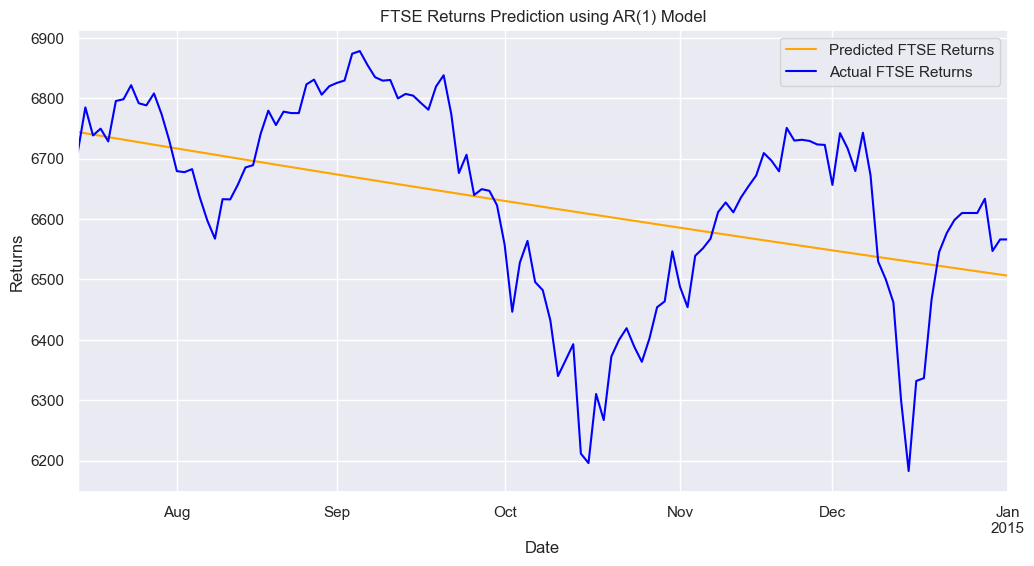

In [48]:
#plot the predictions
plt.figure(figsize=(12, 6))
df_pred[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using AR(1) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

* This suggests that AR model is not good for non stationary data predictions

### Using Returns

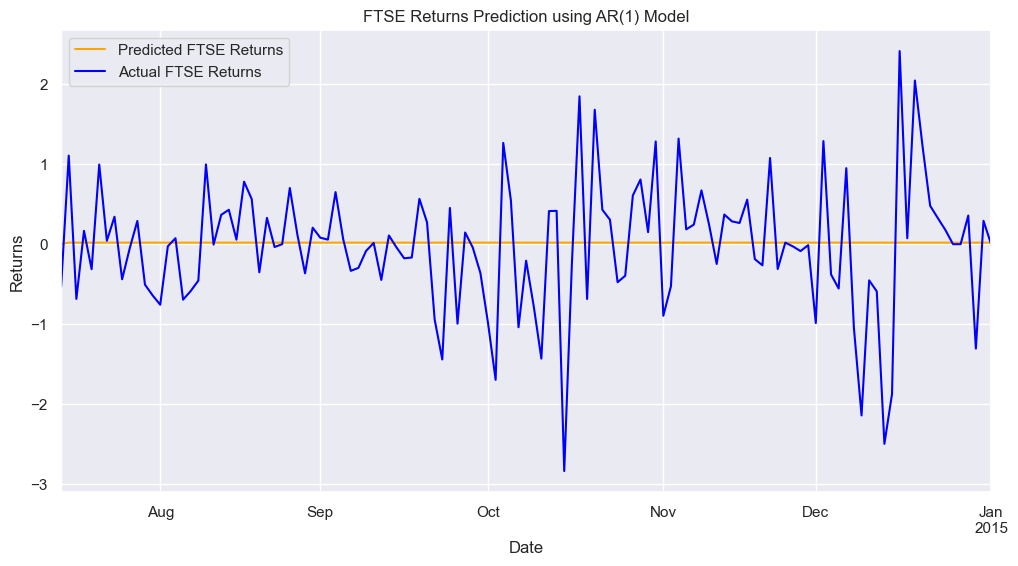

In [49]:
model_ret_ar = ARIMA(df.ret_ftse, order=(1, 0, 0))
result_ret_ar = model_ret_ar.fit()

# Predicting returns
df_ret_pred_ar = result_ret_ar.predict(start=start_date, end=end_date)
# Plotting the predicted returns
plt.figure(figsize=(12, 6))
df_ret_pred_ar[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ret_ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using AR(1) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

* Our model makes no predictions

## MA models

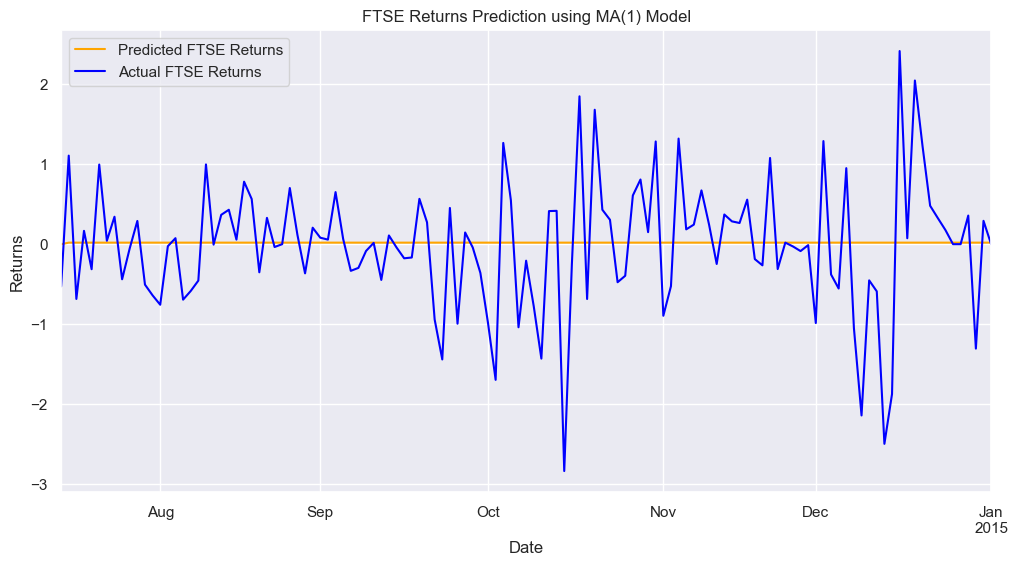

In [50]:
model_ret_ma = ARIMA(df.ret_ftse, order=(0, 0, 1))
result_ret_ma = model_ret_ma.fit()
# Predicting returns
df_ret_pred_ma = result_ret_ma.predict(start=start_date, end=end_date)
# Plotting the predicted returns
plt.figure(figsize=(12, 6))
df_ret_pred_ma[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ret_ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using MA(1) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

* No predictions using MA model as well

## ARMA Model

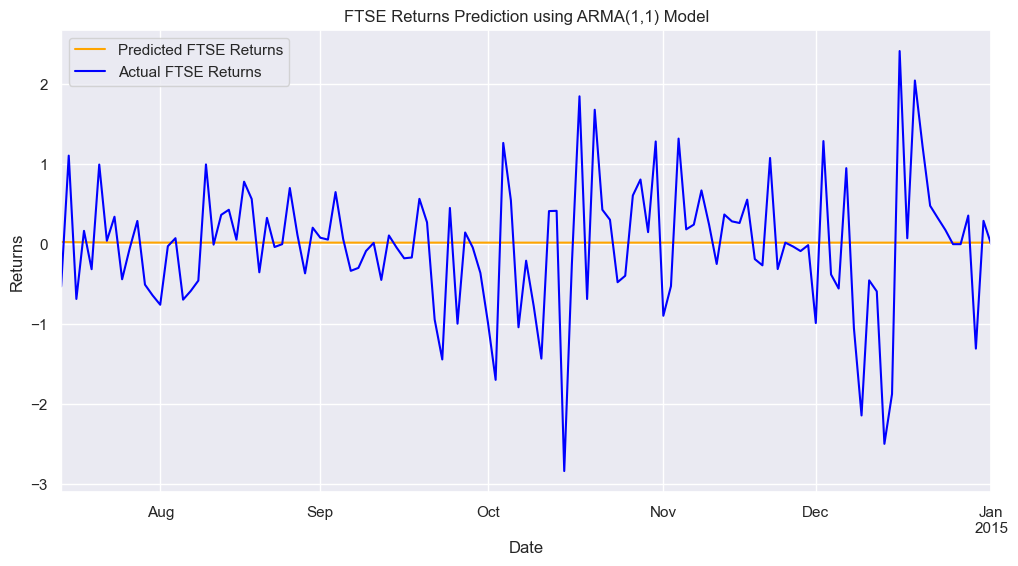

In [51]:
model_ret_arma = ARIMA(df.ret_ftse, order=(1, 0, 1))
result_ret_arma = model_ret_arma.fit()
# Predicting returns
df_ret_pred_arma = result_ret_arma.predict(start=start_date, end=end_date)
# Plotting the predicted returns
plt.figure(figsize=(12, 6))
df_ret_pred_arma[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ret_ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using ARMA(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [52]:
df_ret_pred_arma.head(5)

2014-07-15    0.027408
2014-07-16    0.025573
2014-07-17    0.024148
2014-07-18    0.023043
2014-07-21    0.022185
Freq: B, Name: predicted_mean, dtype: float64

In [53]:
df_ret_pred_arma.tail(5)

2014-12-26    0.019214
2014-12-29    0.019214
2014-12-30    0.019214
2014-12-31    0.019214
2015-01-01    0.019214
Freq: B, Name: predicted_mean, dtype: float64

* using ARMA model, the predictions are decreasing constantly from start and end date. So we must try fitting higher lag models to find whether there are any osillating values in the predictions which is pretty good

## ARMAX Model

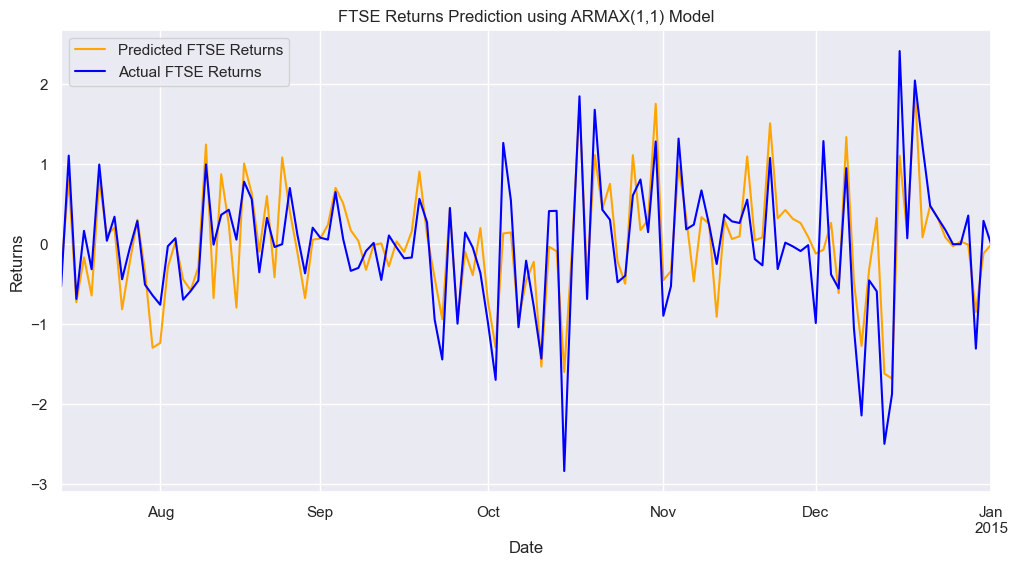

In [54]:
model_ret_armax = ARIMA(df.ret_ftse, order=(1, 0, 1), exog=df[['ret_spx', 'ret_dax', 'ret_nikkei']])
result_ret_armax = model_ret_armax.fit()
# Predicting returns with exogenous variables
df_ret_pred_armax = result_ret_armax.predict(start=start_date, end=end_date, exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])
# Plotting the predicted returns
plt.figure(figsize=(12, 6))
df_ret_pred_armax[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ret_ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using ARMAX(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

## ARIMA model

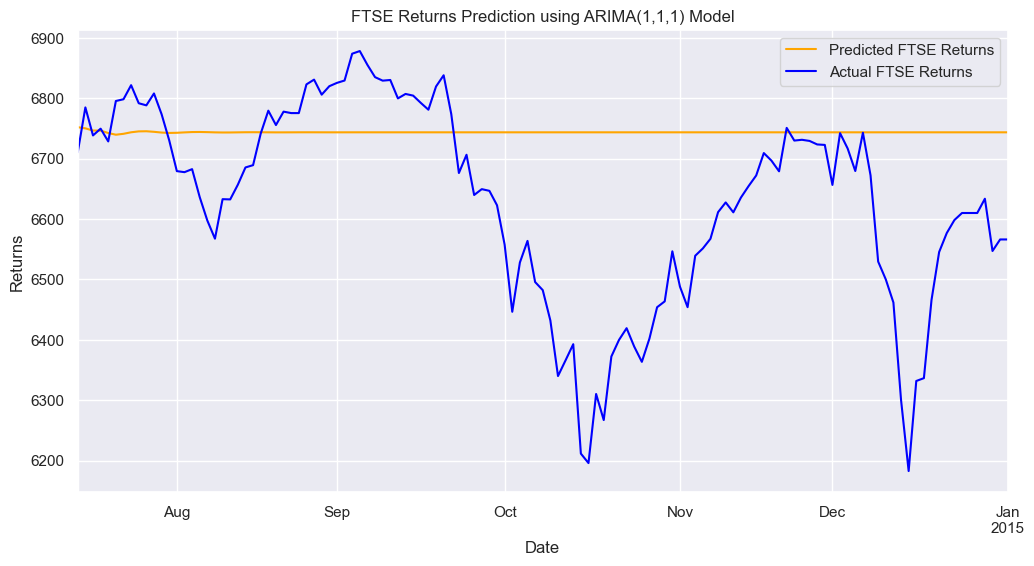

In [55]:
model_arima = ARIMA(df.ftse , order=(4, 1, 5))
result_arima = model_arima.fit()
# Predicting returns with exogenous variables
df_ret_pred_arima = result_arima.predict(start=start_date, end=end_date)
# Plotting the predicted returns
plt.figure(figsize=(12, 6))
df_ret_pred_arima[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using ARIMA(1,1,1) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

## ARIMAX Model

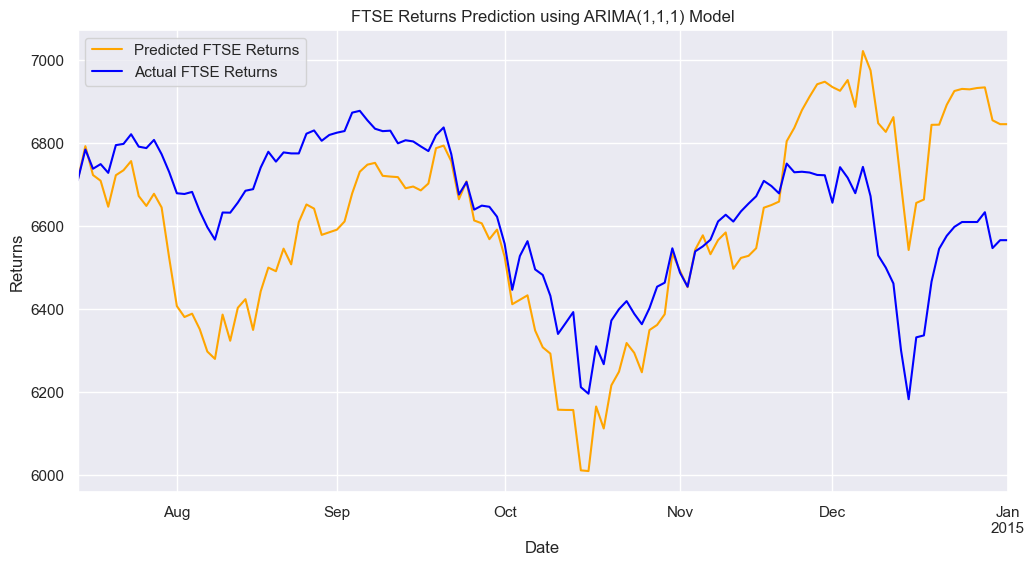

In [56]:
model_arimax = ARIMA(df.ftse , order=(1, 1, 1), exog=df[['spx', 'dax', 'nikkei']])
result_arimax = model_arimax.fit()
# Predicting returns with exogenous variables
df_ret_pred_arimax = result_arimax.predict(start=start_date, end=end_date, exog=df_test[['spx', 'dax', 'nikkei']][start_date:end_date])
# Plotting the predicted returns
plt.figure(figsize=(12, 6))
df_ret_pred_arimax[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using ARIMA(1,1,1) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

### This might seem to be predicting well but this is just performing well on the out of  sample test. For predicting the actual returns you need to make very good forecasting of the exogeneous data which is unlikely. So this model will perform poorly on the new unseen data.

## SARMA Model

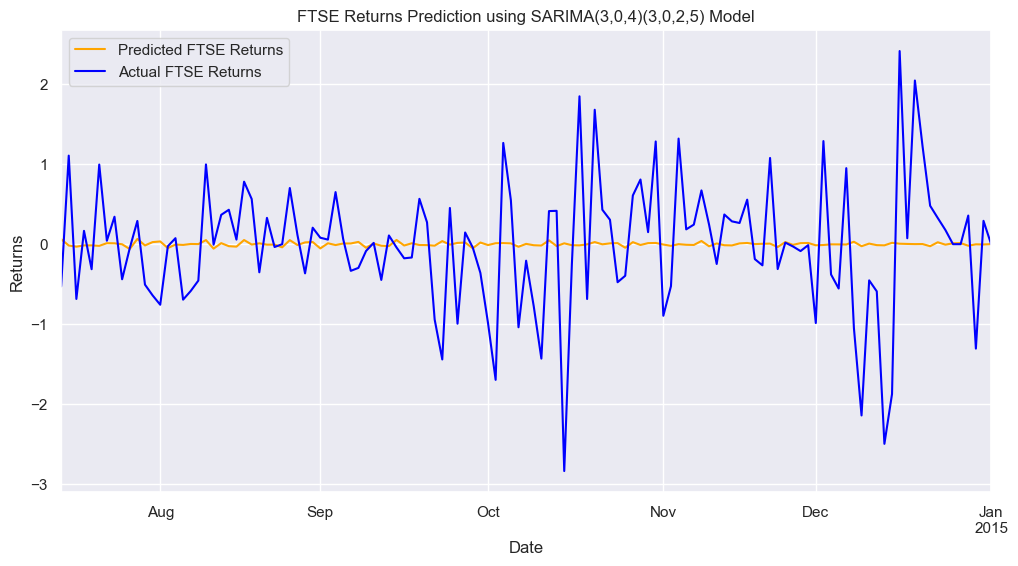

In [57]:
model_ret_sarma = SARIMAX(df.ret_ftse, order=(3,0,4), seasonal_order=(3, 0, 2, 5))
result_ret_sarma = model_ret_sarma.fit()
# Predicting returns with seasonal ARIMA model
df_ret_pred_sarma = result_ret_sarma.predict(start=start_date, end=end_date)
# Plotting the predicted returns
plt.figure(figsize=(12, 6))
df_ret_pred_sarma[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ret_ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using SARIMA(3,0,4)(3,0,2,5) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


## SARIMAX Model

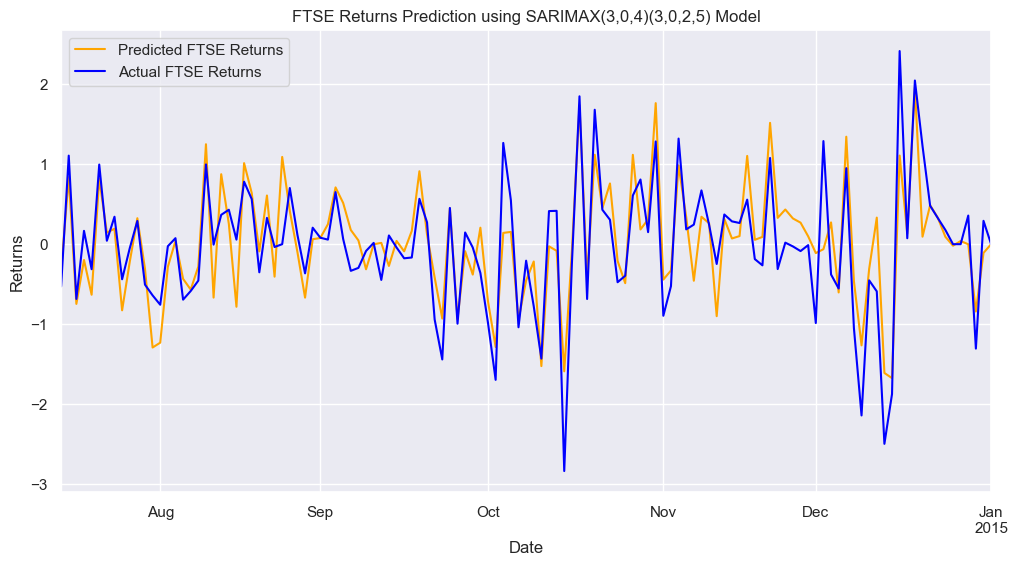

In [58]:
model_ret_sarimax = SARIMAX(df.ret_ftse, order=(3,0,4), seasonal_order=(3, 0, 2, 5), exog=df[['ret_spx', 'ret_dax', 'ret_nikkei']])
result_ret_sarimax = model_ret_sarimax.fit()
# Predicting returns with exogenous variables
df_ret_pred_sarimax = result_ret_sarimax.predict(start=start_date, end=end_date, exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])
# Plotting the predicted returns
plt.figure(figsize=(12, 6))
df_ret_pred_sarimax[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ret_ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using SARIMAX(3,0,4)(3,0,2,5) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

### In reality exog variables are hardly available for long term predictions.

### Comparing all the models

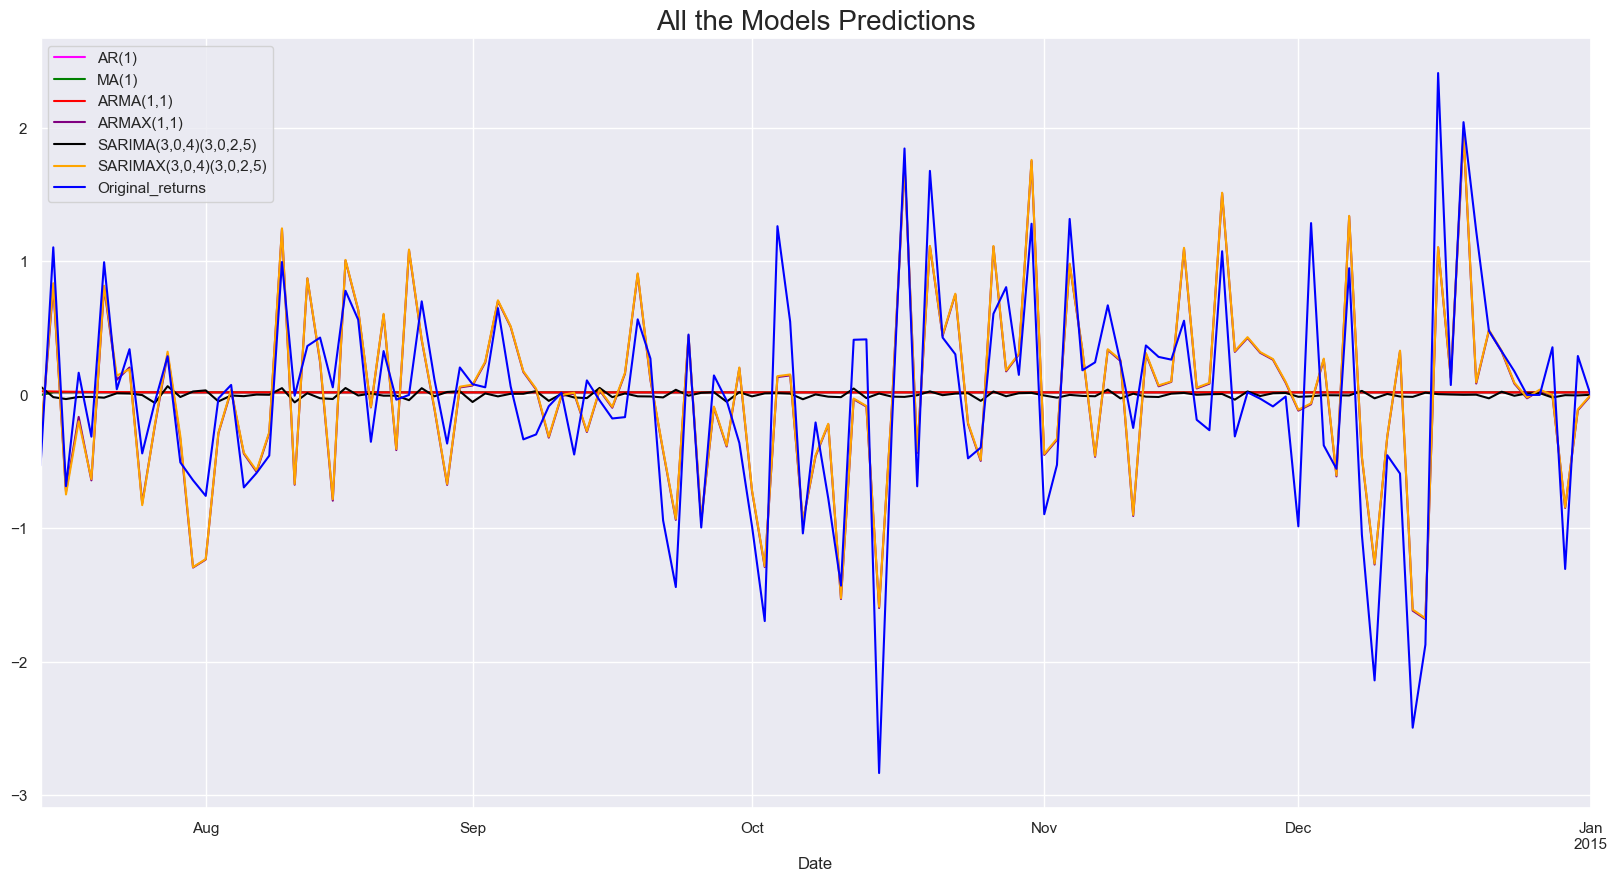

In [63]:
df_ret_pred_ar[start_date:end_date].plot(figsize=(20,10), color = 'magenta')
df_ret_pred_ma[start_date:end_date].plot(color = 'green')
df_ret_pred_arma[start_date:end_date].plot(color = 'red')
df_ret_pred_armax[start_date:end_date].plot(color = 'purple')
df_ret_pred_sarma[start_date:end_date].plot(color = 'black')
df_ret_pred_sarimax[start_date:end_date].plot(color = 'orange')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.legend(['AR(1)', 'MA(1)', 'ARMA(1,1)', 'ARMAX(1,1)', 'SARIMA(3,0,4)(3,0,2,5)', 'SARIMAX(3,0,4)(3,0,2,5)','Original_returns'])
plt.title("All the Models Predictions", size=20)
plt.show()